## Load Data

In [ ]:
!pip install pyarrow
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd 
import gc
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
train_raw = pd.read_parquet("./drive/MyDrive/Colab Notebooks/data/feature_u_m_um_b_c_mb_mc", engine="pyarrow")

In [ ]:
train_raw.head(10)

,merchant_id,cat_id,brand_id,user_id,label,gender,age,item_id,u_ttl_clk_atc_cnt,u_ttl_buy_cnt,u_ttl_atf_cnt,u_clk_atc_cnt_m5,u_clk_atc_cnt_m6,u_clk_atc_cnt_m7,u_clk_atc_cnt_m8,u_clk_atc_cnt_m9,u_clk_atc_cnt_m10,u_clk_atc_cnt_m11,u_buy_cnt_m5,u_buy_cnt_m6,u_buy_cnt_m7,u_buy_cnt_m8,u_buy_cnt_m9,u_buy_cnt_m10,u_buy_cnt_m11,u_atf_cnt_m5,u_atf_cnt_m6,u_atf_cnt_m7,u_atf_cnt_m8,u_atf_cnt_m9,u_atf_cnt_m10,u_atf_cnt_m11,u_ttl_clk_atc_ratio,u_ttl_buy_ratio,u_ttl_atf_ratio,u_clk_atc_ratio_m5,u_clk_atc_ratio_m6,u_clk_atc_ratio_m7,u_clk_atc_ratio_m8,u_clk_atc_ratio_m9,u_clk_atc_ratio_m10,u_clk_atc_ratio_m11,u_buy_ratio_m5,u_buy_ratio_m6,u_buy_ratio_m7,u_buy_ratio_m8,u_buy_ratio_m9,u_buy_ratio_m10,u_buy_ratio_m11,u_atf_ratio_m5,u_atf_ratio_m6,u_atf_ratio_m7,u_atf_ratio_m8,u_atf_ratio_m9,u_atf_ratio_m10,u_atf_ratio_m11,u_clk_atc_day_cnt,u_buy_day_cnt,u_atf_day_cnt,u_clk_atc_day_cnt_m5,u_clk_atc_day_cnt_m6,u_clk_atc_day_cnt_m7,u_clk_atc_day_cnt_m8,u_clk_atc_day_cnt_m9,u_clk_atc_day_cnt_m10,u_clk_atc_day_cnt_m11,u_buy_day_cnt_m5,u_buy_day_cnt_m6,u_buy_day_cnt_m7,u_buy_day_cnt_m8,u_buy_day_cnt_m9,u_buy_day_cnt_m10,u_buy_day_cnt_m11,u_atf_day_cnt_m5,u_atf_day_cnt_m6,u_atf_day_cnt_m7,u_atf_day_cnt_m8,u_atf_day_cnt_m9,u_atf_day_cnt_m10,u_atf_day_cnt_m11,u_clk_atc_item_div,u_buy_item_div,u_atf_item_div,u_clk_atc_cat_div,u_buy_cat_div,u_atf_cat_div,u_clk_atc_brd_div,u_buy_brd_div,u_atf_brd_div,u_clk_atc_mer_div,u_buy_mer_div,u_atf_mer_div,u_clk_atc_mean,u_buy_mean,u_atf_mean,u_clk_atc_median,u_buy_median,u_atf_median,u_clk_atc_std,u_buy_std,u_atf_std,u_clk_atc_max,u_buy_max,u_atf_max,u_clk_atc_day_cnt_mean,u_clk_atc_day_cnt_max,u_clk_atc_day_cnt_std,u_clk_atc_day_cnt_med,u_buy_day_cnt_mean,u_buy_day_cnt_max,u_buy_day_cnt_std,u_buy_day_cnt_med,u_atf_day_cnt_mean,u_atf_day_cnt_max,u_atf_day_cnt_std,u_atf_day_cnt_med,u_clk_atc_item_cnt_mean,u_clk_atc_item_cnt_max,u_clk_atc_item_cnt_std,u_clk_atc_item_cnt_med,u_buy_item_cnt_mean,u_buy_item_cnt_max,u_buy_item_cnt_std,u_buy_item_cnt_med,u_atf_item_cnt_mean,u_atf_item_cnt_max,u_atf_item_cnt_std,u_atf_item_cnt_med,u_clk_atc_cnt_double11,u_buy_cnt_double11,u_atf_cnt_double11,u_clk_atc_cnt_1wpre_double11,u_buy_cnt_1wpre_double11,u_atf_cnt_1wpre_double11,u_clk_atc_ratio_double11,u_clk_atc_ratio_1wpre_double11,u_buy_ratio_double11,u_buy_ratio_1wpre_double11,u_atf_ratio_double11,u_atf_ratio_1wpre_double11,m_ttl_clk_atc_cnt,m_ttl_buy_cnt,m_ttl_atf_cnt,m_clk_atc_cnt_m5,m_clk_atc_cnt_m6,m_clk_atc_cnt_m7,m_clk_atc_cnt_m8,m_clk_atc_cnt_m9,m_clk_atc_cnt_m10,m_clk_atc_cnt_m11,m_buy_cnt_m5,m_buy_cnt_m6,m_buy_cnt_m7,m_buy_cnt_m8,m_buy_cnt_m9,m_buy_cnt_m10,m_buy_cnt_m11,m_atf_cnt_m5,m_atf_cnt_m6,m_atf_cnt_m7,m_atf_cnt_m8,m_atf_cnt_m9,m_atf_cnt_m10,m_atf_cnt_m11,m_ttl_clk_atc_ratio,m_ttl_buy_ratio,m_ttl_atf_ratio,m_clk_atc_ratio_m5,m_clk_atc_ratio_m6,m_clk_atc_ratio_m7,m_clk_atc_ratio_m8,m_clk_atc_ratio_m9,m_clk_atc_ratio_m10,m_clk_atc_ratio_m11,m_buy_ratio_m5,m_buy_ratio_m6,m_buy_ratio_m7,m_buy_ratio_m8,m_buy_ratio_m9,m_buy_ratio_m10,m_buy_ratio_m11,m_atf_ratio_m5,m_atf_ratio_m6,m_atf_ratio_m7,m_atf_ratio_m8,m_atf_ratio_m9,m_atf_ratio_m10,m_atf_ratio_m11,m_clk_atc_day_cnt,m_buy_day_cnt,m_atf_day_cnt,m_clk_atc_day_cnt_m5,m_clk_atc_day_cnt_m6,m_clk_atc_day_cnt_m7,m_clk_atc_day_cnt_m8,m_clk_atc_day_cnt_m9,m_clk_atc_day_cnt_m10,m_clk_atc_day_cnt_m11,m_buy_day_cnt_m5,m_buy_day_cnt_m6,m_buy_day_cnt_m7,m_buy_day_cnt_m8,m_buy_day_cnt_m9,m_buy_day_cnt_m10,m_buy_day_cnt_m11,m_atf_day_cnt_m5,m_atf_day_cnt_m6,m_atf_day_cnt_m7,m_atf_day_cnt_m8,m_atf_day_cnt_m9,m_atf_day_cnt_m10,m_atf_day_cnt_m11,m_clk_atc_item_div,m_buy_item_div,m_atf_item_div,m_clk_atc_cat_div,m_buy_cat_div,m_atf_cat_div,m_clk_atc_brd_div,m_buy_brd_div,m_atf_brd_div,m_clk_atc_mer_div,m_buy_mer_div,m_atf_mer_div,m_clk_atc_mean,m_buy_mean,m_atf_mean,m_clk_atc_median,m_buy_median,m_atf_median,m_clk_atc_std,m_buy_std,m_atf_std,m_clk_atc_max,m_buy_max,m_atf_max,m_clk_atc_day_cnt_mean,m_clk_atc_day_cnt_max,m_clk_atc_day_cnt_std,m_clk_atc_day_cnt_med,m_buy_day_cnt_mean,m_bu

In [ ]:
train_raw.shape[1]

588

In [ ]:
train = train_raw.dropna()
del train_raw
gc.collect()

45190

In [ ]:
train["gender"] = train["gender"].astype("int8")
train["age"] = train["age"].astype("int8")
train["m_popular_age"] = train["m_popular_age"].astype("int8")
train["m_popular_gender"] = train["m_popular_gender"].astype("int8")

## Feature Selection

### Nearly Zero Variance

In [ ]:
train_X, train_y = train.drop(["user_id", "merchant_id", "label", "item_id", "cat_id", "brand_id"], axis=1), train["label"]

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score

var_thres = VarianceThreshold(threshold=0.05)
var_thres.fit(train_X)

# 交叉验证
train_X_varthresh = train_X.iloc[:,var_thres.get_support(indices=True)]
print("使用方差阈值筛选出来的特征结果索引:",var_thres.get_support(indices=True))

使用方差阈值筛选出来的特征结果索引: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  29  30  31  32  33  34  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 103 104 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 235 239 240 242 243 244 245 246 247 248 250 251 252 254 255 256
 257 258 259 266 267 268 269 270 271 272 273 274 275 276 277 278 279 286
 290 291 292 293 294 295 302 303 310 318 320 322 323 324 325 326 327 340
 341 342 343 344 345 346 347 348

In [ ]:
train_X_varthresh.head(1)

,gender,age,u_ttl_clk_atc_cnt,u_ttl_buy_cnt,u_ttl_atf_cnt,u_clk_atc_cnt_m5,u_clk_atc_cnt_m6,u_clk_atc_cnt_m7,u_clk_atc_cnt_m8,u_clk_atc_cnt_m9,u_clk_atc_cnt_m10,u_clk_atc_cnt_m11,u_buy_cnt_m5,u_buy_cnt_m6,u_buy_cnt_m7,u_buy_cnt_m8,u_buy_cnt_m9,u_buy_cnt_m10,u_buy_cnt_m11,u_atf_cnt_m5,u_atf_cnt_m6,u_atf_cnt_m7,u_atf_cnt_m8,u_atf_cnt_m9,u_atf_cnt_m10,u_atf_cnt_m11,u_clk_atc_ratio_m5,u_clk_atc_ratio_m6,u_clk_atc_ratio_m7,u_clk_atc_ratio_m8,u_clk_atc_ratio_m9,u_clk_atc_ratio_m10,u_clk_atc_day_cnt,u_buy_day_cnt,u_atf_day_cnt,u_clk_atc_day_cnt_m5,u_clk_atc_day_cnt_m6,u_clk_atc_day_cnt_m7,u_clk_atc_day_cnt_m8,u_clk_atc_day_cnt_m9,u_clk_atc_day_cnt_m10,u_clk_atc_day_cnt_m11,u_buy_day_cnt_m5,u_buy_day_cnt_m6,u_buy_day_cnt_m7,u_buy_day_cnt_m8,u_buy_day_cnt_m9,u_buy_day_cnt_m10,u_buy_day_cnt_m11,u_atf_day_cnt_m5,u_atf_day_cnt_m6,u_atf_day_cnt_m7,u_atf_day_cnt_m8,u_atf_day_cnt_m9,u_atf_day_cnt_m10,u_atf_day_cnt_m11,u_clk_atc_item_div,u_buy_item_div,u_atf_item_div,u_clk_atc_cat_div,u_buy_cat_div,u_atf_cat_div,u_clk_atc_brd_div,u_buy_brd_div,u_atf_brd_div,u_clk_atc_mer_div,u_buy_mer_div,u_atf_mer_div,u_clk_atc_mean,u_buy_mean,u_atf_mean,u_clk_atc_median,u_buy_median,u_atf_median,u_clk_atc_std,u_buy_std,u_atf_std,u_clk_atc_max,u_buy_max,u_atf_max,u_clk_atc_day_cnt_mean,u_clk_atc_day_cnt_max,u_clk_atc_day_cnt_std,u_buy_day_cnt_max,u_buy_day_cnt_std,u_atf_day_cnt_mean,u_atf_day_cnt_max,u_atf_day_cnt_std,u_atf_day_cnt_med,u_clk_atc_item_cnt_mean,u_clk_atc_item_cnt_max,u_clk_atc_item_cnt_std,u_clk_atc_item_cnt_med,u_buy_item_cnt_mean,u_buy_item_cnt_max,u_buy_item_cnt_std,u_buy_item_cnt_med,u_atf_item_cnt_mean,u_atf_item_cnt_max,u_atf_item_cnt_std,u_atf_item_cnt_med,u_clk_atc_cnt_double11,u_buy_cnt_double11,u_atf_cnt_double11,u_clk_atc_cnt_1wpre_double11,u_buy_cnt_1wpre_double11,u_atf_cnt_1wpre_double11,u_clk_atc_ratio_double11,u_clk_atc_ratio_1wpre_double11,u_buy_ratio_double11,m_ttl_clk_atc_cnt,m_ttl_buy_cnt,m_ttl_atf_cnt,m_clk_atc_cnt_m5,m_clk_atc_cnt_m6,m_clk_atc_cnt_m7,m_clk_atc_cnt_m8,m_clk_atc_cnt_m9,m_clk_atc_cnt_m10,m_clk_atc_cnt_m11,m_buy_cnt_m5,m_buy_cnt_m6,m_buy_cnt_m7,m_buy_cnt_m8,m_buy_cnt_m9,m_buy_cnt_m10,m_buy_cnt_m11,m_atf_cnt_m5,m_atf_cnt_m6,m_atf_cnt_m7,m_atf_cnt_m8,m_atf_cnt_m9,m_atf_cnt_m10,m_atf_cnt_m11,m_clk_atc_day_cnt,m_buy_day_cnt,m_atf_day_cnt,m_clk_atc_day_cnt_m5,m_clk_atc_day_cnt_m6,m_clk_atc_day_cnt_m7,m_clk_atc_day_cnt_m8,m_clk_atc_day_cnt_m9,m_clk_atc_day_cnt_m10,m_clk_atc_day_cnt_m11,m_buy_day_cnt_m5,m_buy_day_cnt_m6,m_buy_day_cnt_m7,m_buy_day_cnt_m8,m_buy_day_cnt_m9,m_buy_day_cnt_m10,m_buy_day_cnt_m11,m_atf_day_cnt_m5,m_atf_day_cnt_m6,m_atf_day_cnt_m7,m_atf_day_cnt_m8,m_atf_day_cnt_m9,m_atf_day_cnt_m10,m_atf_day_cnt_m11,m_clk_atc_item_div,m_buy_item_div,m_atf_item_div,m_clk_atc_cat_div,m_buy_cat_div,m_atf_cat_div,m_clk_atc_brd_div,m_buy_brd_div,m_atf_brd_div,m_clk_atc_mean,m_buy_mean,m_atf_mean,m_clk_atc_median,m_buy_median,m_atf_median,m_clk_atc_std,m_buy_std,m_atf_std,m_clk_atc_max,m_buy_max,m_atf_max,m_clk_atc_day_cnt_mean,m_clk_atc_day_cnt_max,m_clk_atc_day_cnt_std,m_buy_day_cnt_max,m_atf_day_cnt_max,m_atf_day_cnt_std,m_clk_atc_item_cnt_mean,m_clk_atc_item_cnt_max,m_clk_atc_item_cnt_std,m_clk_atc_item_cnt_med,m_buy_item_cnt_mean,m_buy_item_cnt_max,m_buy_item_cnt_std,m_atf_item_cnt_mean,m_atf_item_cnt_max,m_atf_item_cnt_std,m_clk_atc_cnt_double11,m_buy_cnt_double11,m_atf_cnt_double11,m_clk_atc_cnt_1wpre_double11,m_buy_cnt_1wpre_double11,m_atf_cnt_1wpre_double11,m_rpt_byr_num,m_rpt_byr_day,m_popular_age,m_popular_gender,um_ttl_clk_atc_cnt,um_ttl_buy_cnt,um_ttl_atf_cnt,um_clk_atc_cnt_m5,um_clk_atc_cnt_m6,um_clk_atc_cnt_m7,um_clk_atc_cnt_m8,um_clk_atc_cnt_m9,um_clk_atc_cnt_m10,um_clk_atc_cnt_m11,um_buy_cnt_m11,um_atf_cnt_m8,um_atf_cnt_m9,um_atf_cnt_m10,um_atf_cnt_m11,um_ttl_clk_atc_ratio,um_ttl_buy_ratio,um_clk_atc_ratio_m10,um_clk_atc_ratio_m11,um_buy_ratio_m11,um_clk_atc_day_cnt,um_atf_day_cnt,um_clk_atc_day_cnt_m6,um_clk_atc_day_cnt_m7,um_clk_atc_day_cnt_m8,um_clk_atc_day_cnt_m9,um_clk_atc_day_cnt_m10,um_clk_a

### Correlation Analysis

In [ ]:
from scipy.stats import pearsonr

for i in range(train_X.shape[1]):
  feature1 = train_X.columns[i]
  for j in range(i+1, train_X.shape[1]):
    feature2 = train_X.columns[j]
    pearson_coefficient, p_value = pearsonr(train_X[feature1], train_X[feature2])
    if (pearson_coefficient >= 0.8 and p_value < 0.05):
      print("The correlation of {} and {} is {} and the p-value of the test is {}:".format(feature1, feature2, pearson_coefficient, p_value))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


The correlation of u_ttl_clk_atc_cnt and u_clk_atc_item_div is 0.9555522692450107 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_brd_div is 0.8103496243225226 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_mer_div is 0.8070033931493095 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_mean is 0.9388097120007506 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_median is 0.8843437634451041 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_std is 0.8521048170081718 and the p-value of the test is 0.0:
The correlation of u_ttl_clk_atc_cnt and u_clk_atc_max is 0.8835001358968824 and the p-value of the test is 0.0:
The correlation of u_ttl_buy_cnt and u_buy_day_cnt is 0.86483964767171 and the p-value of the test is 0.0:
The correlation of u_ttl_buy_cnt and u_buy_item_div is 0.9767028056547542 and the p-v

### Low Importance 

In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

X = train_X_varthresh
Y = train_y
names = train_X_varthresh.columns

#n_estimators为森林中树木数量，max_depth树的最大深度
rf = RandomForestRegressor(n_estimators=1000, max_depth=10)
scores = []
for i in range(X.shape[1]):
    #每次选择一个特征，进行交叉验证，训练集和测试集为8:2的比例进行分配，
    #ShuffleSplit()函数用于随机抽样（数据集总数，迭代次数，test所占比例）
    #3折交叉验证
    score = cross_val_score(rf, X.iloc[:, i:i+1], Y, scoring="roc_auc", cv=3)
    scores.append((round(np.mean(score), 3), names[i]))

打印出各个特征所对应的得分
print(sorted(scores, reverse=True))

[(0.631, 'm_clk_atc_cnt_m10'), (0.63, 'm_ttl_clk_atc_cnt'), (0.629, 'm_clk_atc_cnt_m7'), (0.629, 'm_clk_atc_cnt_m11'), (0.627, 'm_clk_atc_cnt_m5'), (0.625, 'm_clk_atc_cnt_m9'), (0.624, 'm_clk_atc_cnt_m8'), (0.623, 'm_ttl_atf_cnt'), (0.622, 'm_buy_cnt_m11'), (0.62, 'm_ttl_buy_cnt'), (0.62, 'm_clk_atc_cnt_m6'), (0.61, 'm_buy_cnt_m9'), (0.607, 'm_buy_cnt_m10'), (0.605, 'm_buy_cnt_m6'), (0.601, 'm_buy_cnt_m7'), (0.6, 'm_atf_cnt_m6'), (0.599, 'm_buy_cnt_m5'), (0.598, 'm_buy_cnt_m8'), (0.598, 'm_atf_cnt_m5'), (0.572, 'u_buy_item_cnt_mean'), (0.571, 'u_buy_item_cnt_max'), (0.565, 'u_clk_atc_item_cnt_mean'), (0.562, 'u_clk_atc_item_cnt_max'), (0.561, 'u_clk_atc_item_cnt_std'), (0.561, 'u_buy_item_cnt_std'), (0.558, 'u_ttl_buy_cnt'), (0.557, 'u_buy_item_div'), (0.556, 'u_clk_atc_day_cnt_max'), (0.554, 'u_clk_atc_day_cnt_std'), (0.554, 'u_clk_atc_day_cnt_mean'), (0.551, 'u_buy_day_cnt'), (0.55, 'u_buy_mean'), (0.549, 'u_buy_cat_div'), (0.548, 'u_clk_atc_mean'), (0.548, 'u_buy_max'), (0.546, 'u_c

## Split the training and testing data

In [ ]:
train_X, train_y = train_X_varthresh, train['label']

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.1)

In [ ]:
model_xgb = xgb.XGBClassifier(
        max_depth=13, # raw8
        n_estimators=500,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        learning_rate=0.05,    
        seed=42        
    )

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=13,
              min_child_weight=300, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

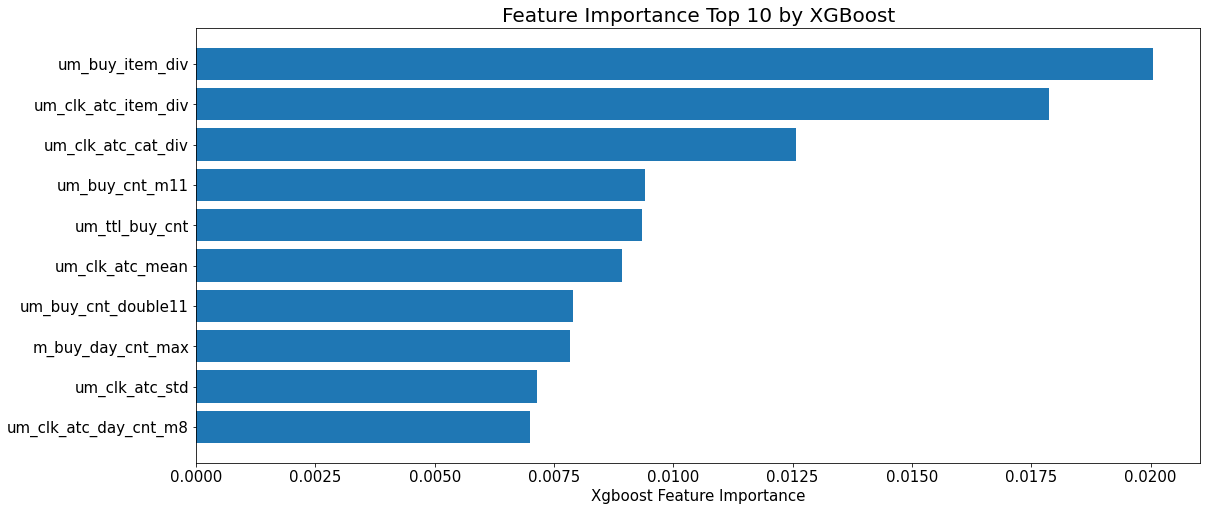

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][394:], model_xgb.feature_importances_[sorted_idx][394:])
plt.xlabel("Xgboost Feature Importance", fontsize=15)
plt.title("Feature Importance Top 10 by XGBoost", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./xgb_feature_importance.png', dpi=300)
plt.show()

## Grid Search

In [ ]:
train_X, train_y = train_X_varthresh, train['label']

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
param_test_1 = {'max_depth': range(7,17,2), 'n_estimators': [100, 500, 800, 1000]}

XGB_model = xgb.XGBClassifier(
        max_depth=10, # raw8
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42,
        tree_method='gpu_hist'        
    )

XGBSearch_1 = GridSearchCV(XGB_model, 
                           param_grid=param_test_1, 
                           scoring='roc_auc', 
                           cv=5, verbose=1)
XGBSearch_1.fit(train_X, train_y)

XGBSearch_1.cv_results_, XGBSearch_1.best_params_, XGBSearch_1.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 36.1min finished


({'mean_fit_time': array([ 5.16981897, 15.35001807, 22.98869534, 28.16641474,  5.51514845,
         17.04547539, 25.73901305, 31.58815823,  5.56063952, 17.95394745,
         27.29889417, 33.57009945,  5.64460073, 18.5015872 , 28.20508165,
         34.70976033,  5.65509224, 18.82318597, 28.70543389, 35.25568714]),
  'mean_score_time': array([0.53384418, 0.89508066, 1.1919075 , 1.43113146, 0.53592486,
         0.9618855 , 1.28105865, 1.52591453, 0.52350488, 0.96786041,
         1.32215285, 1.56629691, 0.52006769, 0.98020425, 1.35593553,
         1.6017724 , 0.51725354, 0.9887269 , 1.38079123, 1.60847011]),
  'mean_test_score': array([0.69135508, 0.69069877, 0.68653613, 0.68313687, 0.69152999,
         0.68897151, 0.68401276, 0.68068447, 0.69266382, 0.689174  ,
         0.68332763, 0.67976213, 0.69269887, 0.68760077, 0.68212881,
         0.67884216, 0.69216121, 0.68697654, 0.68124557, 0.67777657]),
  'param_max_depth': masked_array(data=[7, 7, 7, 7, 9, 9, 9, 9, 11, 11, 11, 11, 13, 13, 13,

In [ ]:
param_test_2 = {'n_estimators': [100, 200, 300, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2]}

XGB_model = xgb.XGBClassifier(
        max_depth=13, # raw8
        n_estimators=100,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42,
        tree_method='gpu_hist'        
    )

XGBSearch_2 = GridSearchCV(XGB_model, 
                           param_grid=param_test_2, 
                           scoring='roc_auc', 
                           cv=5, verbose=1)
XGBSearch_2.fit(train_X, train_y)

XGBSearch_2.cv_results_, XGBSearch_2.best_params_, XGBSearch_2.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 22.1min finished


({'mean_fit_time': array([ 6.93634009, 11.25006948, 15.56818695, 22.68159833,  6.99518557,
         10.81368957, 14.23054471, 20.65763721,  6.41154704,  9.69425864,
         12.80789957, 19.18865643,  6.01793542,  9.20535436, 12.35614324,
         18.74626284,  5.76078825,  9.02840552, 12.1944572 , 18.62070136]),
  'mean_score_time': array([0.56645622, 0.69874215, 0.80412207, 1.00043793, 0.57487411,
         0.67987008, 0.78686833, 1.00907435, 0.56109095, 0.67669024,
         0.79687676, 1.03211584, 0.56736751, 0.68386388, 0.79664073,
         1.02658467, 0.56381402, 0.67860408, 0.79164586, 1.00856929]),
  'mean_test_score': array([0.67839828, 0.68052261, 0.68244242, 0.68798597, 0.68030111,
         0.68544679, 0.69028282, 0.69487019, 0.68773674, 0.69369453,
         0.69523956, 0.6946986 , 0.69269887, 0.69340751, 0.69175495,
         0.68760077, 0.69111811, 0.68580515, 0.68174593, 0.6724347 ]),
  'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02,

## K-fold

In [ ]:
def get_train_testDF(train_df,label_df):
    skv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    trainX = []
    trainY = []
    testX = []
    testY = []
    for train_index, test_index in skv.split(X=train_df, y=label_df):
        train_x, train_y, test_x, test_y = train_df.iloc[train_index, :], label_df.iloc[train_index], \
                                            train_df.iloc[test_index, :], label_df.iloc[test_index]

        trainX.append(train_x)
        trainY.append(train_y)
        testX.append(test_x)
        testY.append(test_y)
    return trainX, testX, trainY, testY

In [ ]:
train_X, train_y = train_X_varthresh, train['label']

X_train, X_valid, y_train, y_valid = get_train_testDF(train_X, train_y)

In [ ]:
del train_X, train_y
gc.collect()

253

In [ ]:
# xgboost模型
%%time
scores = []
for i in range(5):
    print('\n============================XGB training use Data {}/5============================\n'.format(i+1))
    model_xgb = xgb.XGBClassifier(
        max_depth=10, # raw8
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42        
    )

    model_xgb.fit(
        X_train[i], 
        y_train[i],
        eval_metric='auc',
        eval_set=[(X_train[i], y_train[i]), (X_valid[i], y_valid[i])],
        verbose=False,
        early_stopping_rounds=10 # 早停法，如果auc在10epoch没有进步就stop
    )    

    print(model_xgb.best_score)
    scores.append(model_xgb.best_score)
print("AUC: %0.3f (+/- %0.5f)" % (np.mean(scores), np.std(scores)))

In [ ]:
# xgboost模型
%%time
scores = []
for i in range(5):
    print('\n============================XGB training use Data {}/5============================\n'.format(i+1))
    model_xgb = xgb.XGBClassifier(
        max_depth=13, # raw8
        n_estimators=300,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        learning_rate=0.05,    
        seed=42        
    )

    model_xgb.fit(
        X_train[i], 
        y_train[i],
        eval_metric='auc',
        eval_set=[(X_train[i], y_train[i]), (X_valid[i], y_valid[i])],
        verbose=False,
        early_stopping_rounds=10 # 早停法，如果auc在10epoch没有进步就stop
    )    

    print(model_xgb.best_score)
    scores.append(model_xgb.best_score)
print("AUC: %0.3f (+/- %0.5f)" % (np.mean(scores), np.std(scores)))


============================XGB training use Data 1/5============================

0.693469

============================XGB training use Data 2/5============================

0.700771

============================XGB training use Data 3/5============================

0.697317

============================XGB training use Data 4/5============================

0.692766

============================XGB training use Data 5/5============================

0.692709
AUC: 0.695 (+/- 0.00318)
CPU times: user 2h 42min 9s, sys: 5.51 s, total: 2h 42min 15s
Wall time: 2h 42min 48s
